# Build Futures 

In [1]:
import pandas as pd
import numpy as np
from xbbg import blp

import string

import sys
sys.path.insert(0, '../cmds')
from utils import *
from portfolio import *

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

# Futures Contracts

In [49]:
TYPE = 'Comdty'
CODES = ['CL','NG','GC','LA','KC','C ','LC','LH']
bbcodes = [f'{code}A {TYPE}' for code in CODES]

CODES_INDEX = ['ES','NK']
bbcodes += [f'{code}A Index' for code in CODES_INDEX]

CODES_CURNCY = ['BP','BTC']
bbcodes += [f'{code}A Curncy' for code in CODES_CURNCY]

FLDS = ['ID_EXCH_SYMBOL','NAME','SECURITY_TYP','FUTURES_CATEGORY','DERIVATIVE_DELIVERY_TYPE','FUT_EXCH_NAME_LONG','FUT_CONTRACT_DT',
        'FUT_CONT_SIZE', 'CONTRACT_VALUE', 'CRNCY', 'FUT_SEC_SPEC_ML',
        'FUT_TICK_SIZE','FUT_TICK_VAL',        
        'OPEN_INT','VOLUME','VOLUME_AVG_10D']

futures_info = blp.bdp(bbcodes,FLDS)
futures_info.rename(columns={'fut_tick_size':'tick size', 
                             'fut_tick_val':'tick value', 
                             'fut_cont_size':'contract size', 
                             'contract_value':'contract value', 
                             'fut_contract_dt':'contract date',                              
                             'fut_sec_spec_ml':'margin limit', 
                             'open_int':'open interest', 
                             'volume_avg_10d':'volume 10d avg', 
                             'derivative_delivery_type':'delivery type', 
                             'security_typ':'type',
                             'futures_category':'category',
                             'id_exch_symbol':'symbol',
                             'fut_exch_name_long':'exchange'}, inplace=True)

In [50]:
futures_info.index.name = 'bb ticker'
futures_info = futures_info.loc[bbcodes,:]
futures_info = futures_info.reset_index().set_index('symbol')

futures_info

# Futures Time-Series

In [22]:
TICKS = ['CL','GC']
MONTHS = ['G','J','M','Q']
YR = '2'

FLDS = ['LAST_PRICE','OPEN_INT','VOLUME']
bbcalls = list()
for tick in TICKS:
    bbcalls += [f'{tick}{month}{YR} Comdty' for month in MONTHS]
    
futures_ts = blp.bdh(bbcalls, FLDS, start_date='2018-01-01',end_date='2022-06-30')

In [23]:
futures_ts.index = pd.to_datetime(futures_ts.index)
futures_ts.index.name = 'date'

<AxesSubplot:>

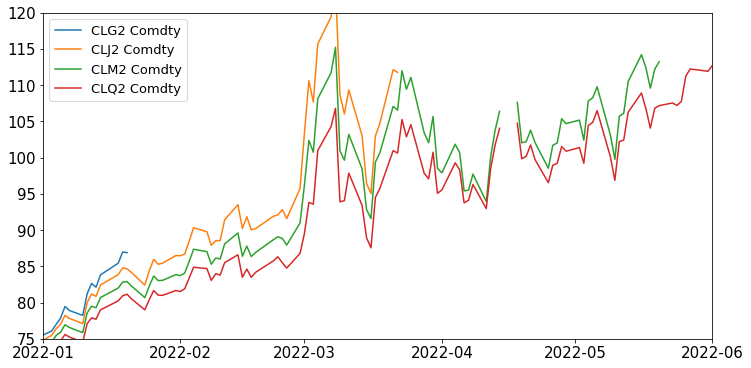

In [5]:
futures_ts.swaplevel(axis=1)['LAST_PRICE'].iloc[:,0:4].plot(xlim=('2022-01','2022-06'),ylim=(75,120))

<AxesSubplot:>

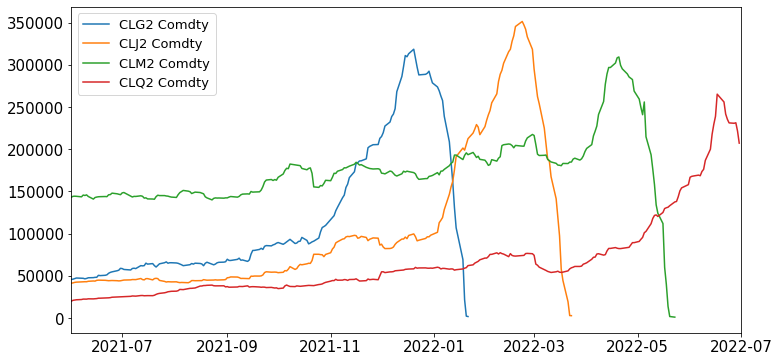

In [6]:
futures_ts.swaplevel(axis=1)['OPEN_INT'].iloc[:,0:4].plot(xlim=('2021-06','2022-07'))

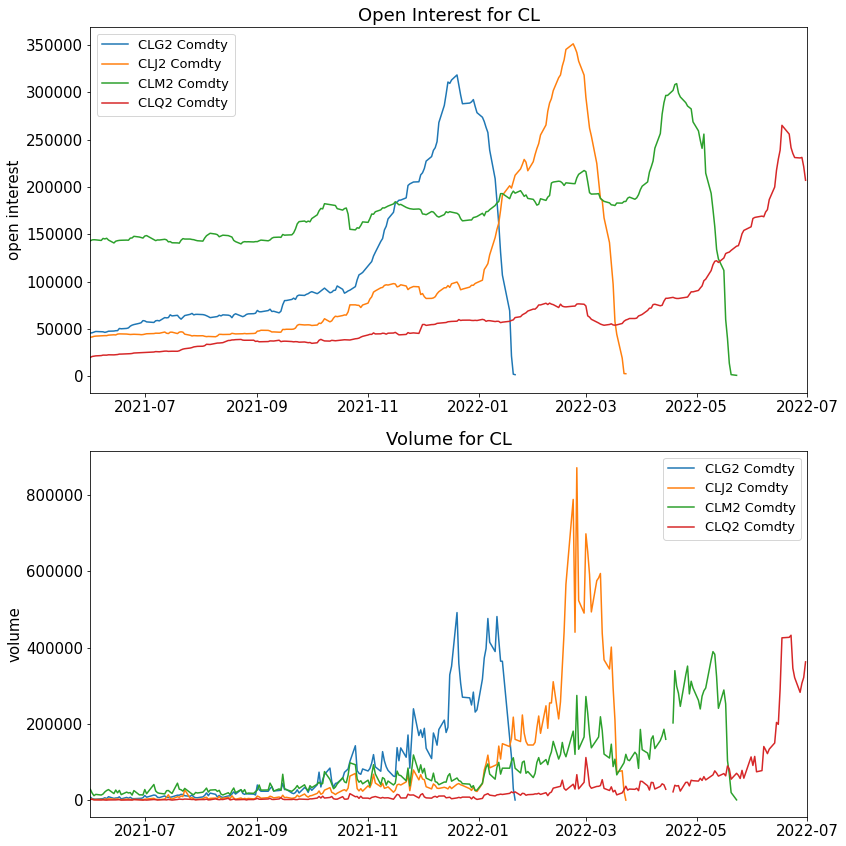

In [7]:
fig, ax = plt.subplots(2,1,figsize=(12,12))
futures_ts.swaplevel(axis=1)['OPEN_INT'].iloc[:,0:4].plot(ax=ax[0],xlim=('2021-06','2022-07'),title=f'Open Interest for {TICKS[0]}',ylabel='open interest')
futures_ts.swaplevel(axis=1)['VOLUME'].iloc[:,0:4].plot(ax=ax[1],xlim=('2021-06','2022-07'),title=f'Volume for {TICKS[0]}',ylabel='volume')
plt.tight_layout()
plt.show()

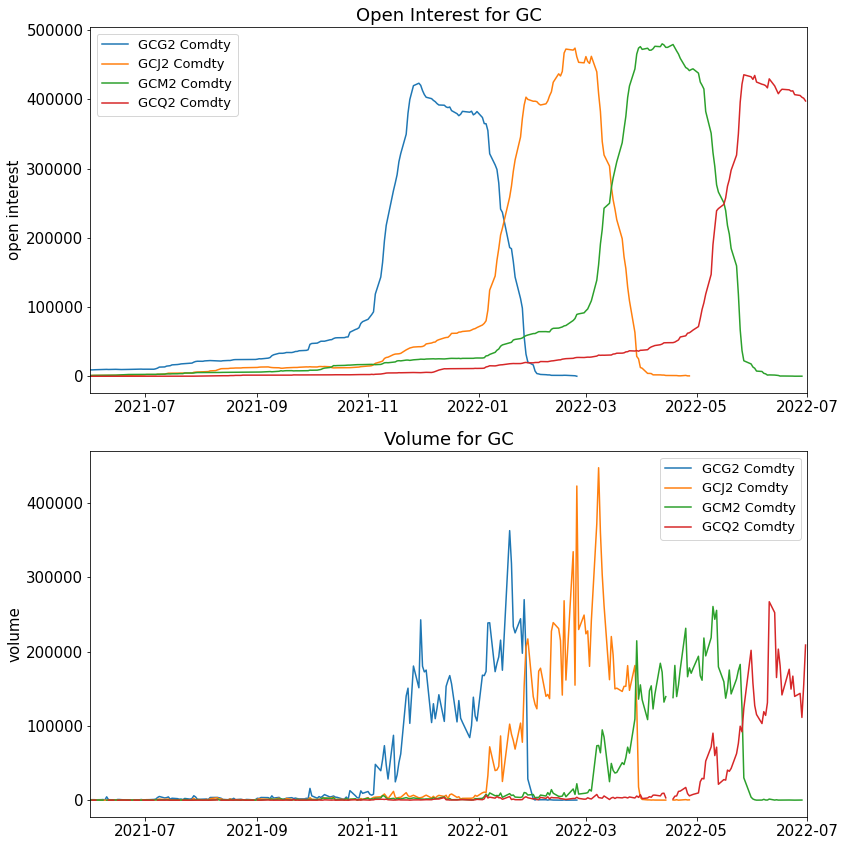

In [8]:
fig, ax = plt.subplots(2,1,figsize=(12,12))
futures_ts.swaplevel(axis=1)['OPEN_INT'].iloc[:,4:].plot(ax=ax[0],xlim=('2021-06','2022-07'),title=f'Open Interest for {TICKS[1]}',ylabel='open interest')
futures_ts.swaplevel(axis=1)['VOLUME'].iloc[:,4:].plot(ax=ax[1],xlim=('2021-06','2022-07'),title=f'Volume for {TICKS[1]}',ylabel='volume')
plt.tight_layout()
plt.show()

# Continuous Futures Adjustments

In [12]:
TICK = 'CL'
TYPE = 'Comdty'

ROLLS = ['B:00_0_R', 'B:00_0_D', 'B:00_0_W']
ROLLLABS = ['Ratio','Difference','Weighted Avg']

STARTDATE = '2010-01-01'
ENDDATE = '2022-06-30'
FLDS = 'last_price'

In [13]:
bbticks_comp = [f'{TICK}1 {TYPE}', f'{TICK}2 {TYPE}']

for roll in ROLLS:
    bbticks_comp.append(f'{TICK}1 {roll} {TYPE}')
    
data_comp = blp.bdh(tickers=bbticks_comp, flds=FLDS, start_date=STARTDATE,
                     end_date=ENDDATE)

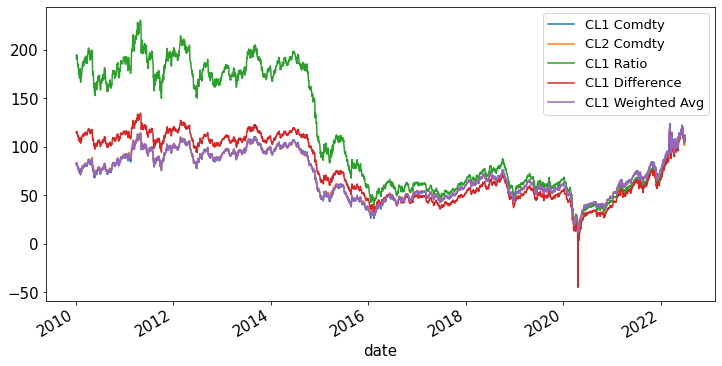

In [14]:
data_comp = data_comp.droplevel(level=1,axis=1)

data_comp.index = pd.to_datetime(data_comp.index)
data_comp.index.name = 'date'
data_comp.columns = [f'{TICK}1 {TYPE}', f'{TICK}2 {TYPE}'] + [f'{TICK}1 {rolllab}' for rolllab in ROLLLABS]

data_comp.plot();

In [15]:
px = data_comp.copy()
px[px<0] = np.nan
px[px==np.inf] = np.nan
rx = px.pct_change()
performanceMetrics(rx,annualization=252)

,Mean,Vol,Sharpe,Min,Max
CL1 Comdty,0.121340,0.442393,0.274280,-0.452107,0.376623
CL2 Comdty,0.119013,0.458751,0.259429,-0.433676,0.788245
CL1 Ratio,0.049540,0.431632,0.114774,-0.452090,0.250893
CL1 Difference,0.194452,0.616400,0.315464,-0.732270,0.731788
CL1 Weighted Avg,0.109426,0.418831,0.261265,-0.307113,0.243738


# Continuous Futures Data

In [16]:
STARTDATE = '2000-01-01'
ENDDATE = '2022-06-30'

ADJ = 'B:00_0_R'
ADJLAB = 'roll=ratio'

bbcodes_adj = [f'{code}1 {ADJ} {TYPE}' for code in CODES]
bbcodes_adj += [f'{code}1 {ADJ} Index' for code in CODES_INDEX]
bbcodes_adj += [f'{code}1 Curncy' for code in CODES_CURNCY]

futures_hist = blp.bdh(bbcodes_adj,'PX_LAST',start_date=STARTDATE,end_date=ENDDATE)

In [17]:
prices = futures_hist.droplevel(level=1,axis=1)
prices.columns = [col.split()[0] for col in prices.columns]
prices.index.name = 'date'

,CL1,NG1,GC1,LA1,KC1,C,LC1,LH1,ES1,NK1,BP1,BTC1
date,,,,,,,,,,,,
2000-01-03,NaN,NaN,NaN,4163.75,1251.52,1465.500,127.654,371.082,1507.14,NaN,163.94,NaN
2000-01-04,51.91,374.328,465.76,4115.76,1248.83,1481.875,126.509,368.762,1450.63,14228.0,163.72,NaN
2000-01-05,50.61,372.951,463.14,4165.01,1274.08,1481.875,126.326,365.115,1452.43,13771.0,164.20,NaN
2000-01-06,50.35,377.768,463.63,4172.59,1255.28,1487.375,128.341,365.778,1442.66,13411.0,164.76,NaN
2000-01-07,49.21,373.812,464.45,4202.90,1226.27,1511.125,129.806,368.762,1499.95,13613.0,163.86,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-24,107.62,6.238,1830.30,2445.26,226.60,750.250,133.375,110.925,3916.25,26480.0,122.89,21207.0
2022-06-27,109.57,6.520,1824.80,2479.75,226.00,744.250,133.475,110.175,3903.75,26770.0,122.96,20800.0
2022-06-28,111.76,6.570,1821.20,2475.75,221.90,759.500,132.725,109.925,3825.50,27070.0,122.01,20175.0


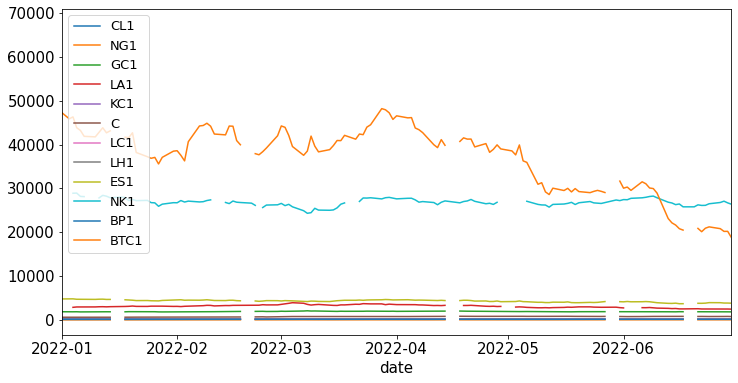

In [18]:
display(prices)
prices.plot(xlim=('2022-01-01','2022-06-30'));

# Futures Curves

In [19]:
bbtick_chain = ['CL1 Comdty','GC1 Comdty']
chain = blp.bds(bbtick_chain,'FUT_CHAIN')

pd_chain = chain.reset_index().set_index('security_description')
list_curves = pd_chain['index'].unique()

FLDS_CURVE = ['FUT_DLV_DT_FIRST','PX_LAST','OPEN_INT']

YRS = 3
SPARSE = 2


curves = dict()

for curve in list_curves:
    if curve == 'CL1 Comdty':
        bb_lookup = pd_chain[pd_chain['index']==curve].iloc[0:YRS*12:SPARSE].index
    elif curve == 'GC1 Comdty':
        bb_lookup = pd_chain[pd_chain['index']==curve].iloc[0:20:SPARSE].index

    curves[curve] = blp.bdp(bb_lookup,FLDS_CURVE).sort_values('fut_dlv_dt_first')
    curves[curve].rename(columns={'fut_dlv_dt_first':'delivery date','open_int':'open interest','px_last':'price'},inplace=True)
    curves[curve][['price','open interest']] = curves[curve][['price','open interest']].astype(float)
    curves[curve].index.name = 'ticker'    

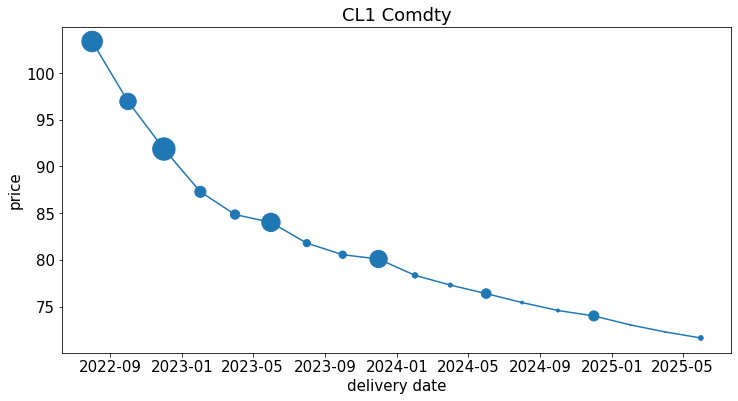

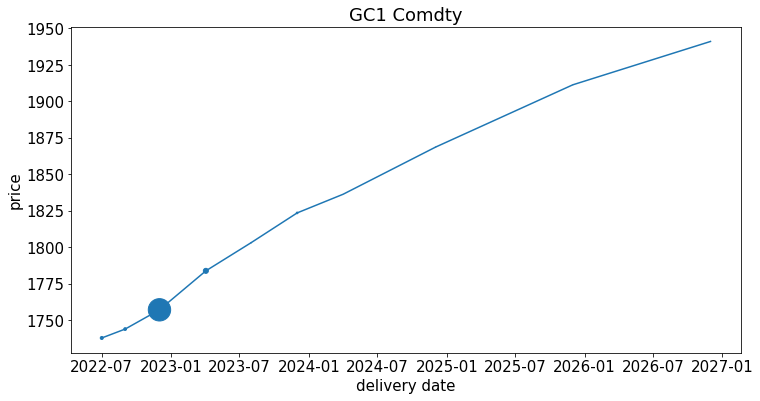

In [20]:
for comdty in list_curves:
    
    temp = curves[comdty].set_index('delivery date').sort_index()
    msize = (temp['open interest']/temp['open interest'].max()) * 500
    
    fig, ax=plt.subplots()
    temp['price'].plot(ax=ax,marker=None,title=comdty)
    temp.reset_index().plot.scatter('delivery date','price',s=msize,ax=ax,title=comdty)
    plt.show()

# Export Data

In [52]:
OUTFILE = f'../data/futures_data.xlsx'

with pd.ExcelWriter(OUTFILE) as writer:  

    futures_info.to_excel(writer, sheet_name= f'futures contracts', index=True)

    futures_ts.to_excel(writer, sheet_name= f'futures timeseries', index=True)    
    
    data_comp.to_excel(writer, sheet_name= f'roll conventions {TICK}', index=True)        
    
    prices.to_excel(writer, sheet_name= f'continuous futures {ADJLAB}', index=True)    
    
    for comdty in list_curves:
        temp = curves[comdty].sort_values('delivery date')
        temp.to_excel(writer, sheet_name= f'curve {comdty.split()[0]}', index=True)        